In [135]:
import numpy as np
import xarray as xr
import rasterio.features
import pystac
import planetary_computer
from rasterio.enums import Resampling
import rioxarray
import xrspatial.multispectral as ms
import dask
from dask_gateway import GatewayCluster
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from math import nan

In [136]:
b = [-2009488, -715776, 1401061, 2597757]
resolution = 1000
epsg = 32198
var = "swe"
b_ll = rasterio.warp.transform_bounds(epsg,4326,*b)
b_ll

(-108.94754980834364, 34.9904689028062, -38.70515024659768, 67.31100419958396)

In [137]:
url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/daymet-annual-na"
collection = pystac.read_file(url)
asset = collection.assets["zarr-https"]

In [138]:
import fsspec
import xarray as xr

store = fsspec.get_mapper(asset.href)
ds = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
ds

<xarray.Dataset>
Dimensions:                  (y: 8075, x: 7814, time: 41, nv: 2)
Coordinates:
    lat                      (y, x) float32 dask.array<chunksize=(8075, 7814), meta=np.ndarray>
    lon                      (y, x) float32 dask.array<chunksize=(8075, 7814), meta=np.ndarray>
  * time                     (time) datetime64[ns] 1980-07-01T12:00:00 ... 20...
  * x                        (x) float32 -4.56e+06 -4.559e+06 ... 3.253e+06
  * y                        (y) float32 4.984e+06 4.983e+06 ... -3.09e+06
Dimensions without coordinates: nv
Data variables:
    lambert_conformal_conic  int16 ...
    prcp                     (time, y, x) float32 dask.array<chunksize=(1, 8075, 7814), meta=np.ndarray>
    swe                      (time, y, x) float32 dask.array<chunksize=(1, 8075, 7814), meta=np.ndarray>
    time_bnds                (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    tmax                     (time, y, x) float32 dask.array<chunksize=(1, 8075, 7814), meta=np.ndarray>
    tmin                     (time, y, x) float32 dask.array<chunksize=(1, 8075, 7814), meta=np.ndarray>
    vp                       (time, y, x) float32 dask.array<chunksize=(1, 8075, 7814), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.6
    Version_data:      Daymet Data Version 4.0
    Version_software:  Daymet Software Version 4.0
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    source:            Daymet Software Version 4.0
    start_year:        1980

In [139]:
xr.set_options(keep_attrs=True)

mosaic = ds.sel(time=slice("1985","2019"))[var].mean(dim="time").load()
mosaic


<xarray.DataArray 'swe' (y: 8075, x: 7814)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    lat      (y, x) float32 58.53 58.54 58.54 58.55 ... 10.01 10.01 10.0 10.0
    lon      (y, x) float32 156.4 156.4 156.4 156.4 ... -72.84 -72.83 -72.82
  * x        (x) float32 -4.56e+06 -4.559e+06 -4.558e+06 ... 3.252e+06 3.253e+06
  * y        (y) float32 4.984e+06 4.983e+06 4.982e+06 ... -3.089e+06 -3.09e+06
Attributes:
    cell_methods:  area: mean time: sum within days time: mean over days
    grid_mapping:  lambert_conformal_conic
    long_name:     annual average snow water equivalent
    units:         kg/m2

In [140]:
lcc = ds.variables["lambert_conformal_conic"].attrs

prj_kwargs = dict(
    central_latitude=lcc["latitude_of_projection_origin"],
    central_longitude=lcc["longitude_of_central_meridian"],
    standard_parallels=(lcc["standard_parallel"]),
)
crs = ccrs.LambertConformal(**prj_kwargs)
ds.variables["lambert_conformal_conic"].attrs

{'false_easting': 0.0,
 'false_northing': 0.0,
 'grid_mapping_name': 'lambert_conformal_conic',
 'inverse_flattening': 298.257223563,
 'latitude_of_projection_origin': 42.5,
 'longitude_of_central_meridian': -100.0,
 'semi_major_axis': 6378137.0,
 'standard_parallel': [25.0, 60.0]}

In [141]:
mosaic=mosaic.rio.write_crs(crs)

In [144]:
mosaic_ql = mosaic.drop('lat').drop('lon').rio.reproject(32198, resolution=resolution, resampling=Resampling.average,nodata=nan).rio.clip_box(*b)
mosaic_ql=mosaic_ql.rio.write_crs(32198)
del mosaic_ql.attrs['grid_mapping']

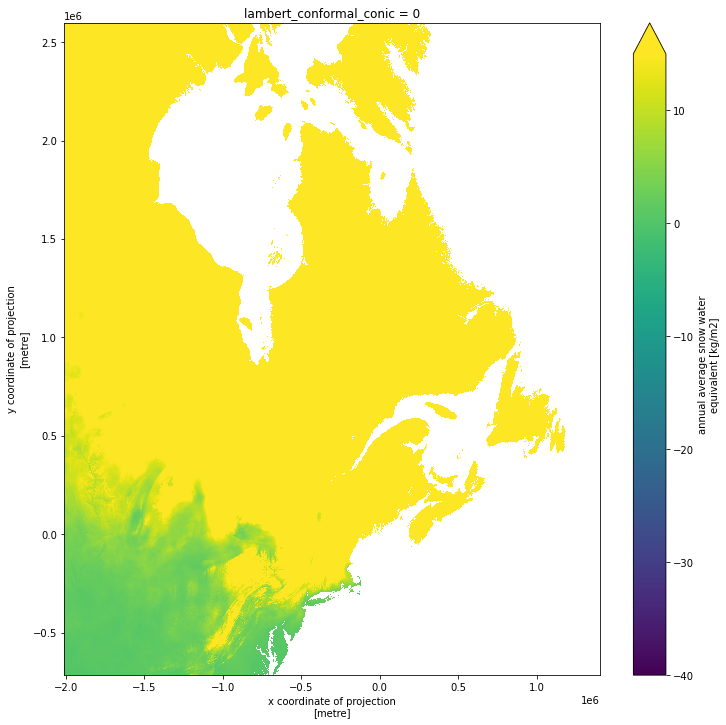

In [145]:
mosaic_ql.plot.imshow(figsize=(12, 12),vmin=-40,vmax=15);

In [147]:
mosaic_ql.rio.to_raster('/home/jovyan/daymet-'+var+'-1985-2019.tif',compress='DEFLATE')